In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import h5py
from load_quilt_data import load_data
import sklearn.metrics as metrics
from visualise_data import plot_confusion_matrix
from pylab import *
import numpy as np
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras import metrics
from keras.activations import relu, sigmoid, softmax
from keras import backend as K
from keras.models import load_model
from keras import optimizers
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [4]:
def readHDF(path):

    with h5py.File(path,'r') as hdf:

                
        Cluster = hdf.get('Cluster')
   
        Cluster_Input = Cluster.get('Input')
        Cluster_Output = Cluster.get('Output')
        
        x_train = np.array(Cluster_Input.get('x_train_mc'))
        y_train = np.array(Cluster_Output.get('y_train_mc'))
        x_test = np.array(Cluster_Input.get('x_test_mc'))
        y_test = np.array(Cluster_Output.get('y_test_mc'))


        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)


        print('x train: ',np.shape(x_train),'y train: ',np.shape(y_train),'x test: ',np.shape(x_test),'y test: ',np.shape(y_test))

        

    return (x_train, y_train, x_test, y_test)





In [5]:
#0= Car in, 1= Car out, 2= Motorcycle, 3= Pedestrian'

In [6]:
#convert cmp data to cn data
def convert_y(ys):
    
    
    new_y = []
    for y in ys:
        if y[3]== 1 or y[2] == 1:
            new_y.append(0)
        else:
            new_y.append(1)
    new_y = np.asarray(new_y)
    return(new_y)
    
### optional ###
        
def fifty_percent(xs,ys):

    i = 0
    j = 0
    x_train_new = []
    y_train_new = []
    for y, x in zip(ys, xs):
        if y == 1:
            i +=1
    
            if i < 231:
                x_train_new.append(x)
                y_train_new.append(y)
        else:
            j += 1
            if j <231:
                x_train_new.append(x)
                y_train_new.append(y)
                

    return(np.asarray(x_train_new), np.asarray(y_train_new))

#0= Car in, 1= Car out, 2= Motorcycle, 3= Pedestrian'



In [7]:
path = "D:\\ParkHere\\Hdf_data\\081118_Hdf_all_data_right_norm.h5"
x_train, y_train_cmp, x_test, y_test_cmp = readHDF(path)
y_train_cn = convert_y(y_train_cmp)
y_test_cn = convert_y(y_test_cmp)
print('x train: ',np.shape(x_train),'y train: ',np.shape(y_train_cn),'x test: ',np.shape(x_test),'y test: ',np.shape(y_test_cn))

### optional for 50/50 car/no car ###
x_train, y_train_cn = fifty_percent(x_train, y_train_cn)
print('x train: ',np.shape(x_train),'y train: ',np.shape(y_train_cn),'x test: ',np.shape(x_test),'y test: ',np.shape(y_test_cn))
print(y_train_cn[0:100])

x train:  (3259, 61, 4) y train:  (3259, 4) x test:  (814, 61, 4) y test:  (814, 4)
x train:  (3259, 61, 4) y train:  (3259,) x test:  (814, 61, 4) y test:  (814,)
x train:  (460, 61, 4) y train:  (460,) x test:  (814, 61, 4) y test:  (814,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]


In [8]:
#validate model
def plot_wrongs(modelPath, x_test, y_test):
    
    model = load_model(modelPath)
    layer_output = model.predict(x_test, verbose = 0)
    layer_output = np.round(layer_output)

    #print(np.shape(y_test), y_diff, layer_output[0:100])
    #y_true_labels = np.argmax(y_test, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

    #y_pred_labels = np.argmax(layer_output, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
    confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=layer_output) 
    class_names = ('0', '1')
    plt.figure()
    plot_confusion_matrix(confusion_matrix, classes=class_names,
                          title='Confusion matrix')
    return(layer_output)
    




In [9]:
# make new input and output, only cars: binary output for car in or car out
def create_new_test_data(layer_output,x_test):
    
    new_output = []
    new_x_test = []
    for l,x,y in zip(layer_output, x_test, y_test):

        if l == 1:
            if y[0] == 1:
                new_output.append(0)
                new_x_test.append(x)

            elif y[1] == 1:
                new_output.append(1)
                new_x_test.append(x)


    new_output = np.asarray(new_output)
    new_x_test = np.asarray(new_x_test)
    print(shape(new_output), shape(new_x_test))
    return(new_output, new_x_test)

In [11]:
from pylab import *
import numpy as np

def plot_data(training_loss, val_loss, epochs):

    plt.figure(figsize=(10, 4))
    x_ax = np.arange(1, len(val_loss)+1,1)
    #import pdb; pdb.set_trace()
    plt.plot(x_ax, val_loss, 'bo', label='Test accuracy')
    plt.plot(x_ax, training_loss, label='Training accuracy')
    plt.legend()
    plt.xlabel('Nr. of epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Performance 1D Convolution after '+ str(len(val_loss))+' epochs, '+ 'accuracy: '+ str(val_loss[-1]))
    plt.show()

In [12]:
class Net(object):


    def __init__(self, batch_size, epochs, optimizer, activation, minDelta, patience ):


        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.activation = activation
        self.minDelta = minDelta
        self.patience = patience

    ##### Creation of the model
    def createModel(self):
        model = Sequential()
        # for the input shape keras ignores first dimension (batch size)
        model.add(Convolution1D(filters=10, kernel_size=7, activation=self.activation, padding='same', input_shape=(61, 4))) 
        model.add(MaxPooling1D())
        model.add(Convolution1D(filters=20, kernel_size=7, padding='same', activation=self.activation)) 
        model.add(MaxPooling1D())
        model.add(Convolution1D(filters=40, kernel_size=7 ,padding='same', activation=self.activation)) 
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(30))
        model.add(Dense(1,activation=self.activation))

        return(model)

    ##### Execution/Training of the model
    def exeModel(self, x_train, x_test, y_train, y_test):
        model = self.createModel()
        esCallBack = keras.callbacks.EarlyStopping(min_delta=self.minDelta, patience=self.patience, restore_best_weights = True)

        model.compile(loss='binary_crossentropy',
                      optimizer=self.optimizer,metrics=["accuracy"])
        history = model.fit(x_train, y_train,
                            batch_size=self.batch_size,
                            epochs=self.epochs,
                            verbose=1,
                            validation_data=(x_test, y_test), callbacks = [esCallBack])
        model.summary()
        model.save('D:\ParkHere\Keras_models\CNN_model_'+'cn_fifty'+'.h5')
        plot_data(history.history['acc'],history.history['val_acc'], self.epochs)
        return('Done')
        #return(history.history['loss'],history.history['val_loss'])


 Activation: sigmoid, Optimizer: <keras.optimizers.Adam object at 0x000001FAAE3FC0B8>, Batch size: 20 Stops at 50 epochs, if no minimum improvement of: 0
Train on 460 samples, validate on 814 samples
Epoch 1/400
460/460 [==============================] - ETA: 16s - loss: 0.6251 - acc: 0.70 - ETA: 1s - loss: 0.7791 - acc: 0.4550 - ETA: 0s - loss: 0.7524 - acc: 0.473 - 1s 2ms/step - loss: 0.7465 - acc: 0.4696 - val_loss: 0.7951 - val_acc: 0.0713
Epoch 2/400
460/460 [==============================] - ETA: 0s - loss: 0.6077 - acc: 0.750 - ETA: 0s - loss: 0.6763 - acc: 0.510 - ETA: 0s - loss: 0.6457 - acc: 0.664 - 0s 431us/step - loss: 0.6401 - acc: 0.6804 - val_loss: 0.5348 - val_acc: 0.9865
Epoch 3/400
460/460 [==============================] - ETA: 0s - loss: 0.5545 - acc: 1.000 - ETA: 0s - loss: 0.5200 - acc: 0.933 - ETA: 0s - loss: 0.4314 - acc: 0.959 - 0s 498us/step - loss: 0.4186 - acc: 0.9587 - val_loss: 0.2558 - val_acc: 0.9607
Epoch 4/400
460/460 [==============================] -

Epoch 33/400
460/460 [==============================] - ETA: 0s - loss: 0.0077 - acc: 1.000 - ETA: 0s - loss: 0.0157 - acc: 0.990 - ETA: 0s - loss: 0.0133 - acc: 0.995 - 0s 428us/step - loss: 0.0228 - acc: 0.9935 - val_loss: 0.0388 - val_acc: 0.9828
Epoch 34/400
460/460 [==============================] - ETA: 0s - loss: 0.0261 - acc: 1.000 - ETA: 0s - loss: 0.0144 - acc: 1.000 - ETA: 0s - loss: 0.0210 - acc: 0.997 - 0s 458us/step - loss: 0.0207 - acc: 0.9978 - val_loss: 0.0377 - val_acc: 0.9828
Epoch 35/400
460/460 [==============================] - ETA: 0s - loss: 0.0078 - acc: 1.000 - ETA: 0s - loss: 0.0374 - acc: 0.995 - ETA: 0s - loss: 0.0223 - acc: 0.997 - 0s 431us/step - loss: 0.0203 - acc: 0.9978 - val_loss: 0.0208 - val_acc: 0.9939
Epoch 36/400
460/460 [==============================] - ETA: 0s - loss: 0.0081 - acc: 1.000 - ETA: 0s - loss: 0.0426 - acc: 0.990 - ETA: 0s - loss: 0.0260 - acc: 0.995 - 0s 433us/step - loss: 0.0230 - acc: 0.9957 - val_loss: 0.0278 - val_acc: 0.9914


Epoch 66/400
460/460 [==============================] - ETA: 0s - loss: 0.0027 - acc: 1.000 - ETA: 0s - loss: 8.1099e-04 - acc: 1.000 - ETA: 0s - loss: 0.0015 - acc: 1.0000    - 0s 431us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0350 - val_acc: 0.9889
Epoch 67/400
460/460 [==============================] - ETA: 0s - loss: 1.5978e-04 - acc: 1.000 - ETA: 0s - loss: 8.2205e-04 - acc: 1.000 - 0s 372us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9889
Epoch 68/400
460/460 [==============================] - ETA: 0s - loss: 2.0305e-04 - acc: 1.000 - ETA: 0s - loss: 0.0018 - acc: 1.0000    - 0s 369us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9889
Epoch 69/400
460/460 [==============================] - ETA: 0s - loss: 8.2041e-05 - acc: 1.000 - ETA: 0s - loss: 9.6974e-04 - acc: 1.000 - ETA: 0s - loss: 0.0010 - acc: 1.0000    - 0s 403us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9902
Epoch 70/400
460/460 [==================

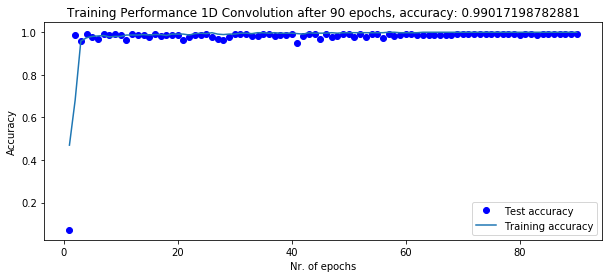

'Done'

In [57]:
##### Hyperparameters
sgd = optimizers.SGD(lr=0.01)
adam = keras.optimizers.Adam()
batchsize = 20
epochs = 400
optimizer = adam
activation = 'sigmoid'
minDelta = 0
patience = 50

print ( ' Activation: '+activation+ ', Optimizer: '+str(optimizer)+
        ', Batch size: '+ str(batchsize)+' Stops at '+
       str(patience) + ' epochs, if no minimum improvement of: ' + str(minDelta))

Network = Net(batchsize, epochs, optimizer, activation, minDelta, patience)

Network.exeModel(x_train, x_test, y_train_cn, y_test_cn)


Confusion matrix, without normalization


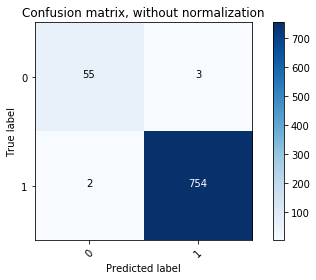

In [58]:
import sklearn.metrics as metrics

modelPath = 'D:\ParkHere\Keras_models\CNN_model_'+'cn_fifty'+'.h5'
layer_output  = plot_wrongs(modelPath, x_test, y_test_cn)
